In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt  
#Altair for statistical visualization

import statsmodels.api as sm 
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [7]:
#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
import yfinance as yf

bse_data = yf.download('^BSESN', start='2019-01-01', end='2022-03-31')
#since our Textual Analysis dataset containing news from Times of India News Headlines is only till Apr 13, 2022. 
#So we will assume today is Apr 13, 2022 and tomorrow is Apr 14, 2022. 
#And we have to predict the stock price ((high+low+close)/3) and closing price of BSE index for tomorrow.

unseenbse_data = yf.download('^BSESN', start='2022-03-31', end='2022-04-01') 
#date to predict stock price

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
bse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [10]:
unseenbse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [11]:
bse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 
                         'adjclose', 'Volume': 'volume'}, inplace = True)

In [12]:
unseenbse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 
                               'adjclose', 'Volume': 'volume'}, inplace = True)
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 797 entries, 2019-01-02 to 2022-03-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      797 non-null    float64
 1   high      797 non-null    float64
 2   low       797 non-null    float64
 3   close     797 non-null    float64
 4   adjclose  797 non-null    float64
 5   volume    797 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.6 KB


In [13]:
unseenbse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2022-03-31 to 2022-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1 non-null      float64
 1   high      1 non-null      float64
 2   low       1 non-null      float64
 3   close     1 non-null      float64
 4   adjclose  1 non-null      float64
 5   volume    1 non-null      int64  
dtypes: float64(5), int64(1)
memory usage: 56.0 bytes


In [14]:
bse_data.head()

,open,high,low,close,adjclose,volume
Date,,,,,,
2019-01-02,36198.128906,36236.699219,35734.011719,35891.519531,35891.519531,14705400
2019-01-03,35934.500000,35999.660156,35475.570312,35513.710938,35513.710938,17400
2019-01-04,35590.789062,35744.199219,35382.078125,35695.101562,35695.101562,15855600
2019-01-07,35971.179688,36076.949219,35809.230469,35850.160156,35850.160156,14831200
2019-01-08,35964.621094,36037.351562,35753.949219,35980.929688,35980.929688,16218000


In [15]:
bse_data.tail()

,open,high,low,close,adjclose,volume
Date,,,,,,
2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300
2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100
2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300


In [16]:
unseenbse_data.head()

,open,high,low,close,adjclose,volume
Date,,,,,,
2022-03-31,58779.710938,58890.921875,58485.789062,58568.511719,58568.511719,4400


In [17]:
bse_data.reset_index(inplace=True)
bse_data.rename(columns={'Date': 'date'}, inplace = True)
bse_data.head()

,date,open,high,low,close,adjclose,volume
0,2019-01-02,36198.128906,36236.699219,35734.011719,35891.519531,35891.519531,14705400
1,2019-01-03,35934.500000,35999.660156,35475.570312,35513.710938,35513.710938,17400
2,2019-01-04,35590.789062,35744.199219,35382.078125,35695.101562,35695.101562,15855600
3,2019-01-07,35971.179688,36076.949219,35809.230469,35850.160156,35850.160156,14831200
4,2019-01-08,35964.621094,36037.351562,35753.949219,35980.929688,35980.929688,16218000


In [18]:
unseenbse_data.reset_index(inplace=True)
unseenbse_data.rename(columns={'Date': 'date'}, inplace = True)
unseenbse_data.head()

,date,open,high,low,close,adjclose,volume
0,2022-03-31,58779.710938,58890.921875,58485.789062,58568.511719,58568.511719,4400


In [19]:
bse_data['date'] = pd.to_datetime(bse_data['date'], format = '%Y%m%d')
unseenbse_data['date'] = pd.to_datetime(unseenbse_data['date'], format = '%Y%m%d')

#calculating the actual price
unseenbsedata_price = round((unseenbse_data['high'] + unseenbse_data['low'] + unseenbse_data['close'])/ 3, 2)
unseenbsedata_price  #actual price

0    58648.41
dtype: float64

In [20]:
def stock_weekmovingavg(wks, df):
  dateclose_data = pd.DataFrame({'date': df['date'], 'close':df['close']})
  dateclose_data.set_index('date', inplace=True)
    
  num = wks * 5                     
  #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
    
  dateclose_data['movingavg'] = dateclose_data['close'].rolling(window=num).mean().shift()
  return dateclose_data.dropna()

stock_weekmovingavg(4, bse_data).head()

,close,movingavg
date,,
2019-01-30,35591.250000,36055.822266
2019-01-31,36256.691406,36040.808789
2019-02-01,36469.429688,36077.957812
2019-02-04,36582.738281,36116.674219
2019-02-05,36616.808594,36153.303125


<AxesSubplot:xlabel='date'>

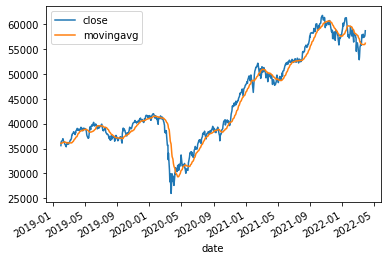

In [21]:
stock_weekmovingavg(4, bse_data).plot()

In [22]:
altdata_fourweek = stock_weekmovingavg(4, bse_data)
altdata_fourweek.reset_index(inplace=True)
altdata_fourweek.rename(columns={list(altdata_fourweek)[0]:'date'}, inplace=True)

alt.Chart(altdata_fourweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

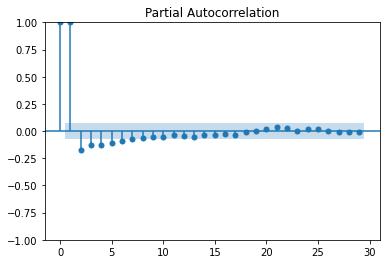

In [23]:
plotfourweek = altdata_fourweek.filter(['date', 'movingavg'], axis=1) 
plotfourweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fourweek['date']))) 

del plotfourweek['date']
sm.graphics.tsa.plot_pacf(plotfourweek.values.squeeze())
plt.show()

In [24]:
#In the partial autocorrelation plot above, we have statistically significant partial autocorrelations 
#at lag values 0 to 30. Where 0, 1 represents a perfect positive correlation 
#and 3, 4, 5, 6, 7 represents a perfect negative correlation. While the rest of values are 
#very close to 0 and under the confidence intervals, which are represented as blue shaded regions.

In [25]:
stock_weekmovingavg(16, bse_data).head()

,close,movingavg
date,,
2019-05-06,38600.339844,37155.013672
2019-05-07,38276.628906,37188.873926
2019-05-08,37789.128906,37223.410400
2019-05-09,37558.910156,37249.585742
2019-05-10,37462.988281,37270.945117


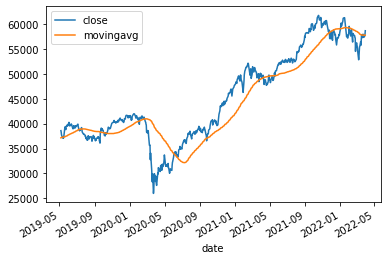

In [26]:
stock_weekmovingavg(16, bse_data).plot()
plt.show()

In [27]:
altdata_sixteenweek = stock_weekmovingavg(16, bse_data)
altdata_sixteenweek.reset_index(inplace=True)
altdata_sixteenweek.rename(columns={list(altdata_sixteenweek)[0]:'date'}, inplace=True)

alt.Chart(altdata_sixteenweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

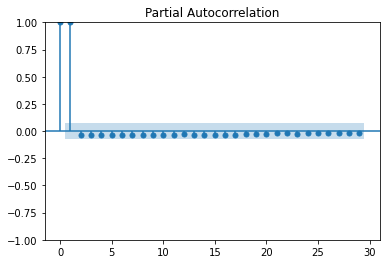

In [28]:
plotsixteenweek = altdata_sixteenweek.filter(['date', 'movingavg'], axis=1)
plotsixteenweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', 
                                                                   length=len(altdata_sixteenweek['date']))) 
del plotsixteenweek['date']
sm.graphics.tsa.plot_pacf(plotsixteenweek.values.squeeze())
plt.show()

In [29]:
#In the partial autocorrelation plot above, we have statistically significant partial autocorrelations 
#at lag values 0 to 30. Where 0, 1 represents a perfect positive correlation. While the rest of values are 
#very close to 0 and under the confidence intervals, which are represented as blue shaded regions.

In [30]:
stock_weekmovingavg(52, bse_data).head()

,close,movingavg
date,,
2020-01-29,41198.660156,38595.272837
2020-01-30,40913.820312,38615.684916
2020-01-31,40723.488281,38636.454567
2020-02-03,39872.308594,38655.794516
2020-02-04,40789.378906,38671.264318


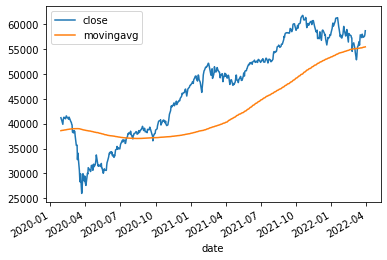

In [31]:
stock_weekmovingavg(52, bse_data).plot()
plt.show()

In [32]:
altdata_fiftytwoweek = stock_weekmovingavg(52, bse_data)
altdata_fiftytwoweek.reset_index(inplace=True)
altdata_fiftytwoweek.rename(columns={list(altdata_fiftytwoweek)[0]:'date'}, inplace=True)

alt.Chart(altdata_fiftytwoweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

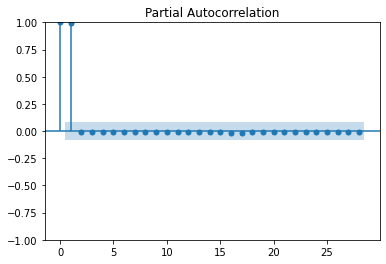

In [33]:
plotfiftytwoweek = altdata_fiftytwoweek.filter(['date', 'movingavg'], axis=1)
plotfiftytwoweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fiftytwoweek['date']))) 
del plotfiftytwoweek['date']
sm.graphics.tsa.plot_pacf(plotfiftytwoweek.values.squeeze())
plt.show()

In [34]:
def rollingwindows(days, df):
  data = df.filter(['date','open','high','low','close'], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  rollingwindows_data = data.rolling(window=days).mean().shift()
  return rollingwindows_data.dropna()

rollingwindows(10, bse_data).head()

,open,high,low,close
date,,,,
2019-01-16,36035.380859,36130.321875,35757.132031,35943.255859
2019-01-17,36052.641797,36152.855078,35811.591797,35986.232812
2019-01-18,36100.551953,36199.731250,35881.114844,36072.269531
2019-01-21,36183.230859,36272.309375,35964.739844,36141.420312
2019-01-22,36232.825000,36334.717578,36018.993750,36214.300391


<AxesSubplot:xlabel='date'>

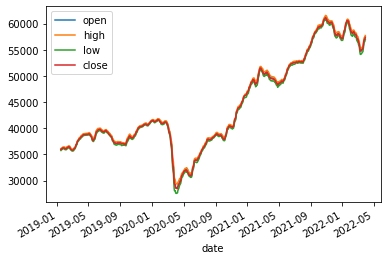

In [35]:
rollingwindows(10, bse_data).plot()

In [36]:
altdata_tendays = rollingwindows(10, bse_data)
altdata_tendays.reset_index(inplace=True)
altdata_tendays.rename(columns={list(altdata_tendays)[0]:'date'}, inplace=True)

alt.Chart(altdata_tendays).mark_point().encode(
    x ='date',
    y = 'close'
)

alt.Chart(...)

In [37]:
rollingwindows(50, bse_data).head()

,open,high,low,close
date,,,,
2019-03-15,36288.940547,36424.037500,36066.417266,36246.664297
2019-03-18,36320.182578,36464.398906,36106.941641,36289.320312
2019-03-19,36364.151797,36511.797500,36156.472266,36340.947500
2019-03-20,36416.707812,36564.834687,36210.395312,36394.314844
2019-03-22,36465.961406,36613.091875,36260.534922,36445.046641


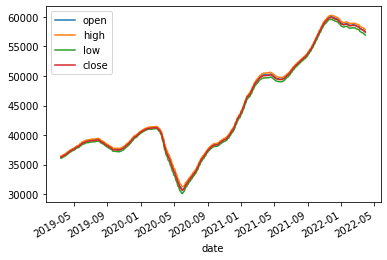

In [38]:
rollingwindows(50, bse_data).plot()
plt.show()

In [39]:
altdata_fiftydays = rollingwindows(50, bse_data)
altdata_fiftydays.reset_index(inplace=True)
altdata_fiftydays.rename(columns={list(altdata_fiftydays)[0]:'date'}, inplace=True)

alt.Chart(altdata_fiftydays).mark_point().encode(
    x='date',
    y='close'
)

alt.Chart(...)

In [40]:
#Creating dummy time-series
#Volume shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether 
#volume traded is 10% higher/lower than previous day. ( 0/1 dummy-coding is for direction of shock)

def boolean_shock(percent, df, col):
  data = df.filter(['date', col], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  data['percentchg'] = (data[col].pct_change()) * 100  
#percentage change compare to previous volume using pct_change() function
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(col, axis = 1, inplace = True)
  return data.dropna()

boolean_shock(10, bse_data, 'volume')

,percentchg,shock
date,,
2019-01-03,-99.881676,0
2019-01-04,91024.137931,1
2019-01-07,-6.460809,0
2019-01-08,9.350558,0
2019-01-09,-99.874830,0
...,...,...
2022-03-24,464.835165,1
2022-03-25,-86.575875,0
2022-03-28,-8.695652,0


In [41]:
altdata_volpercentchg = boolean_shock(10, bse_data, 'volume')
altdata_volpercentchg.reset_index(inplace=True)
altdata_volpercentchg.rename(columns={list(altdata_volpercentchg)[0]:'date'}, inplace=True)

alt.Chart(altdata_volpercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

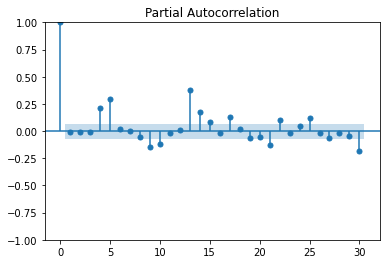

In [42]:
plotvolpercentchg = altdata_volpercentchg.filter(['date', 'percentchg'], axis=1) #df.copy()
plotvolpercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', 
                                                                     length=len(altdata_volpercentchg['date']))) 

del plotvolpercentchg['date']
sm.graphics.tsa.plot_pacf(plotvolpercentchg.values.squeeze())
plt.show()

In [43]:
#In the partial autocorrelation plot above, we have statistically significant partial autocorrelations 
#at lag values 0 to 30. Where 0, 4, 5, 13, 14, 17 represents a perfect positive correlation 
#and 9, 10, 21, 30 represents a perfect negative correlation. While the rest of values are 
#very close to 0 and under the confidence intervals, which are represented as blue shaded regions.

In [44]:
boolean_shock(2, bse_data, 'close')

,percentchg,shock
date,,
2019-01-03,-1.052640,0
2019-01-04,0.510762,0
2019-01-07,0.434397,0
2019-01-08,0.364767,0
2019-01-09,0.644732,0
...,...,...
2022-03-24,-0.154530,0
2022-03-25,-0.405378,0
2022-03-28,0.403208,0


In [45]:
altdata_closepercentchg2 = boolean_shock(2, bse_data, 'close')
altdata_closepercentchg2.reset_index(inplace=True)
altdata_closepercentchg2.rename(columns={list(altdata_closepercentchg2)[0]:'date'}, inplace=True)

alt.Chart(altdata_closepercentchg2).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

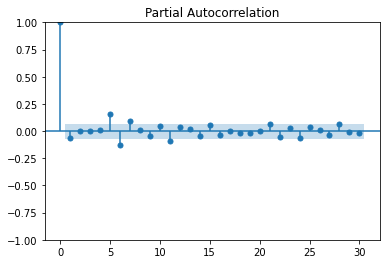

In [46]:
plotclosepercentchg2 = altdata_closepercentchg2.filter(['date', 'percentchg'], axis=1)
plotclosepercentchg2.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', 
                                                                        length=len(altdata_closepercentchg2['date']))) 

del plotclosepercentchg2['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg2.values.squeeze())
plt.show()

In [47]:
boolean_shock(10, bse_data, 'close')

,percentchg,shock
date,,
2019-01-03,-1.052640,0
2019-01-04,0.510762,0
2019-01-07,0.434397,0
2019-01-08,0.364767,0
2019-01-09,0.644732,0
...,...,...
2022-03-24,-0.154530,0
2022-03-25,-0.405378,0
2022-03-28,0.403208,0


In [48]:
altdata_closepercentchg10 = boolean_shock(10, bse_data, 'close')
altdata_closepercentchg10.reset_index(inplace=True)
altdata_closepercentchg10.rename(columns={list(altdata_closepercentchg10)[0]:'date'}, inplace=True)

alt.Chart(altdata_closepercentchg10).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

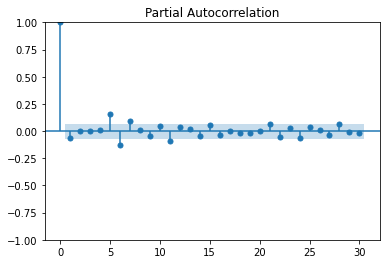

In [49]:
plotclosepercentchg10 = altdata_closepercentchg10.filter(['date', 'percentchg'], axis=1)
plotclosepercentchg10.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', 
                                                                         length=len(altdata_closepercentchg10['date']))) 
del plotclosepercentchg10['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg10.values.squeeze())
plt.show()

In [50]:
def priceboolean_shock(percent, df):
  df['date'] = pd.to_datetime(df['date'])
  data = df.filter(['date', 'high', 'low','close'], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  data['priceavg'] = (data['high'] + data['low'] + data['close']) / 3
  data['shock'] = (data['priceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['high', 'low', 'close'], axis = 1, inplace = True)
  return data

priceboolean_shock(10, bse_data)

,priceavg,shock
date,,
2019-01-02,35954.076823,0
2019-01-03,35662.980469,0
2019-01-04,35607.126302,0
2019-01-07,35912.113281,0
2019-01-08,35924.076823,0
...,...,...
2022-03-24,57520.726562,0
2022-03-25,57435.936198,0
2022-03-28,57352.305990,0


In [51]:
altdata_pricepercentchg = priceboolean_shock(10, bse_data)
altdata_pricepercentchg.reset_index(inplace=True)
altdata_pricepercentchg.rename(columns={list(altdata_pricepercentchg)[0]:'date'}, inplace=True)

alt.Chart(altdata_pricepercentchg).mark_point().encode(
    x='date',
    y='priceavg'
)

alt.Chart(...)

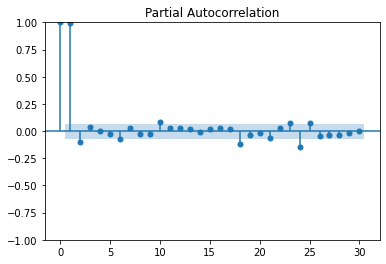

In [52]:
plotpricepercentchg = altdata_pricepercentchg.filter(['date', 'priceavg'], axis=1) #df.copy()
plotpricepercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', 
                                                                       length=len(altdata_pricepercentchg['date']))) 

del plotpricepercentchg['date']
sm.graphics.tsa.plot_pacf(plotpricepercentchg.values.squeeze())
plt.show()

In [53]:
#Creating Reverse Dummy series
def reverseboolean_shock(percent, df, col):
  data = df.filter(['date', col], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['percentchg'] = (data[col].pct_change()) * 100
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x > percent else 0)
  data.drop(col, axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

reverseboolean_shock(2, bse_data, 'close')

,percentchg,shock
date,,
2019-01-02,1.063839,0
2019-01-03,-0.508167,0
2019-01-04,-0.432519,0
2019-01-07,-0.363441,0
2019-01-08,-0.640602,0
...,...,...
2022-03-23,0.154770,0
2022-03-24,0.407028,0
2022-03-25,-0.401589,0


In [54]:
altdata_closepercentchg = reverseboolean_shock(2, bse_data, 'close')
altdata_closepercentchg.reset_index(inplace=True)
altdata_closepercentchg.rename(columns={list(altdata_closepercentchg)[0]:'date'}, inplace=True)

alt.Chart(altdata_closepercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

In [55]:
#Pricing black swan : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether 
#closing price at T vs T+1 has a difference > 2%. ( 0/1 dummy-coding is for direction of shock). 
#This will be reverse of pct_change()

In [56]:
reverseboolean_shock(5, bse_data, 'close')

,percentchg,shock
date,,
2019-01-02,1.063839,0
2019-01-03,-0.508167,0
2019-01-04,-0.432519,0
2019-01-07,-0.363441,0
2019-01-08,-0.640602,0
...,...,...
2022-03-23,0.154770,0
2022-03-24,0.407028,0
2022-03-25,-0.401589,0


In [57]:
altdata_closepercentchg5 = reverseboolean_shock(5, bse_data, 'close')
altdata_closepercentchg5.reset_index(inplace=True)
altdata_closepercentchg5.rename(columns={list(altdata_closepercentchg5)[0]:'date'}, inplace=True)

alt.Chart(altdata_closepercentchg5).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

In [58]:
#Pricing shock without volume shock : Now we will be creating a time series for pricing shock without volume 
#shock based on whether price at T vs T+1 has a difference > 5%. ( 0/1 dummy-coding is for direction of shock). 
#This will be reverse of pct_change()

In [59]:
def pricereverseboolean_shock(percent, df):
  data = df.filter(['date', 'high', 'low','close'], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['reversepriceavg'] = (data['high'] + data['low'] + data['close']) / 3
  data['shock'] = (data['reversepriceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['high', 'low', 'close'], axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

pricereverseboolean_shock(2, bse_data)

,reversepriceavg,shock
date,,
2019-01-02,35954.076823,0
2019-01-03,35662.980469,0
2019-01-04,35607.126302,0
2019-01-07,35912.113281,0
2019-01-08,35924.076823,0
...,...,...
2022-03-24,57520.726562,0
2022-03-25,57435.936198,0
2022-03-28,57352.305990,0


In [60]:
altdata_reversepricepercentchg = pricereverseboolean_shock(2, bse_data)
altdata_reversepricepercentchg.reset_index(inplace=True)
altdata_reversepricepercentchg.rename(columns={list(altdata_reversepricepercentchg)[0]:'date'}, inplace=True)

alt.Chart(altdata_reversepricepercentchg).mark_point().encode(
    x='date',
    y='reversepriceavg'
)

alt.Chart(...)

In [61]:
##Textual Analysis of news from Times of India News Headlines

In [62]:
#reading the uploaded csv file and assigning to news variable
news  = pd.read_csv('india-news-headlines.csv')

#getting the overview of all the columns in the news dataset
news.columns

Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

In [63]:
#finding the total rows and columns of news dataset
news.shape

(3650970, 3)

In [64]:
news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [65]:
#converting publish_date column
news['publish_date'] = pd.to_datetime(news['publish_date'], format = '%Y%m%d')
news.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [66]:
news.tail()

,publish_date,headline_category,headline_text
3650965,2022-03-31,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,2022-03-31,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,2022-03-31,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,2022-03-31,city.erode,Tamil Nadu sees marginal rise of Covid cases w...
3650969,2022-03-31,city.salem,Tamil Nadu sees marginal rise of Covid cases w...


In [67]:
#getting brief overview of the dataset - number of columns and rows (shape of dataset), columns names and 
#its dtype, how many non-null values it has and memory usage.
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 83.6+ MB


In [68]:
#finding unique values in headline_category
news['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [69]:
news['headline_category'].value_counts()

india                                                    297491
unknown                                                  209583
city.mumbai                                              150451
city.delhi                                               137648
business.india-business                                  121195
                                                          ...  
nepal-india-earthquake.opinion                                8
elections.lok-sabha-elections-2019.tripura.news               8
best-products.home-decor-and-garden.living-room-decor         8
profiles.india-profiles                                       8
pms-us-visit                                                  8
Name: headline_category, Length: 1041, dtype: int64

In [70]:
#total unique values count
news['headline_category'].value_counts().count()

1041

In [71]:
news['headline_text'].value_counts()

Straight Answers                                                                                                          6723
Cartoons                                                                                                                  1536
Straight answers                                                                                                          1500
Photogallery                                                                                                              1353
Your say                                                                                                                  1012
                                                                                                                          ... 
Pak President Asif Ali Zardari at 7RCR; meets Manmohan Singh                                                                 1
Why Goa Inc is so happy with CM Manohar Parrikar                                                               

In [72]:
news['headline_text'].value_counts().count()

3387380

In [73]:
news.isnull().sum().sum()

0

In [74]:
news.duplicated().sum()

24860

In [75]:
#Rough checking by marking all duplicates as True. 
#Default is first which marks duplicates as True except for the first occurrence.

news.duplicated(keep=False).sum()

47452

In [76]:
#Sorting the dataset to delete the duplicates, to make duplicates come together one after another. 
#The sorted dataset index values are also changed

cols = list(news.columns)
news.sort_values(by=cols, inplace=True, ignore_index=True)

news[news.duplicated(keep=False)]

,publish_date,headline_category,headline_text
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,America's unwanted heading for India?
5,2001-01-02,unknown,America's unwanted heading for India?
6,2001-01-02,unknown,America's unwanted heading for India?
9,2001-01-02,unknown,BBC's reality TV will focus on AIIMS
...,...,...,...
3646165,2022-03-22,city.hubballi,BJP divided over probable induction of Basavar...
3648600,2022-03-27,city.chennai,Father; daughter killed in TN as e-bike on cha...
3648601,2022-03-27,city.chennai,Father; daughter killed in TN as e-bike on cha...
3649664,2022-03-29,city.hyderabad,Telangana logs 30 new Covid cases


In [77]:
#dropping the duplicates only keeping the last value (ordinally last row from sorted) of each duplicates

news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [78]:
news.duplicated().sum()

0

In [79]:
from textblob import TextBlob

In [80]:
#getting a list of unique dates in publish_date column
lst = news['publish_date'].value_counts().index.tolist()

#concatenating all the headline_text column values of same date in publish_date column
new = []
for x in lst:
  df = news.loc[news['publish_date'] == x]
  headlinetext = ''
  publishdate = str(x)
  headlinetext = df['headline_text'].iloc[0]
  for i in range(1 , len(df)):
    headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
  new.append(headlinetext)

#creating a new dataset
newsdf = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

newsdf

,publish_date,headline_text
0,2014-12-15,Golden Homes III. Golden Panorama. Hanging Gar...
1,2014-12-21,Eight companies add Rs 55;171 crore in m-cap; ...
2,2014-12-09,Audi-Vredestein driving experience. Benelli TN...
3,2014-11-29,6 CARE IPO merchant bankers fined Rs 1 crore. ...
4,2014-12-27,New generation Audi Q7 being tested in India. ...
...,...,...
7712,2001-03-02,Such A Long Journey
7713,2001-05-25,What Women Want
7714,2001-06-05,Darkness Triumphs
7715,2001-03-16,Tape and Tell


In [81]:
newsdf.sort_values(by='publish_date', inplace=True, ignore_index=True)

newsdf.head()

,publish_date,headline_text
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...
4,2001-01-06,Anti-immigration think-tank berates Clinton re...


In [82]:
newsdf.tail()

,publish_date,headline_text
7712,2022-03-27,F1 2022: Sergio Perez grabs pole position at S...
7713,2022-03-28,Adani Total forays into electric mobility infr...
7714,2022-03-29,'ONGC sells Russia's Sokol oil to Indian refin...
7715,2022-03-30,8 days; 7 hikes: Petrol crosses Rs 100/L mark....
7716,2022-03-31,$50 million fund for Apple's supplier employee...


In [83]:
newsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7717 entries, 0 to 7716
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   publish_date   7717 non-null   datetime64[ns]
 1   headline_text  7717 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 120.7+ KB


In [84]:
#We can calculate the sentiment using TextBlob. Based on the polarity, we determine whether it is a positive text 
#or negative or neutral. For TextBlog, if the polarity is more than 0, it is considered positive, if it is less 
#than 0 then it is considered negative and if it ia=s equal to 0 is considered neutral. 
#Subjectivity quantifies the amount of personal opinion and factual information contained in the text. 
#The higher subjectivity means that the text contains personal opinion rather than factual information.

In [85]:
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
  polarity.append(TextBlob(row['headline_text']).sentiment[0])
  subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity

newsdf.head()

,publish_date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [86]:
newsdf.tail()

,publish_date,headline_text,polarity,subjectivity
7712,2022-03-27,F1 2022: Sergio Perez grabs pole position at S...,0.026188,0.371042
7713,2022-03-28,Adani Total forays into electric mobility infr...,0.055232,0.389939
7714,2022-03-29,'ONGC sells Russia's Sokol oil to Indian refin...,0.095037,0.404044
7715,2022-03-30,8 days; 7 hikes: Petrol crosses Rs 100/L mark....,0.037729,0.350965
7716,2022-03-31,$50 million fund for Apple's supplier employee...,0.023654,0.338593


In [87]:
newsdf.isnull().sum().sum()

0

In [88]:
newsdf.rename(columns={'publish_date': 'date'}, inplace = True)

newsdf = newsdf.filter(['date', 'polarity', 'subjectivity'], axis=1)

newsdf.shape

(7717, 3)

In [89]:
newsdf['date'].duplicated().sum()

0

In [90]:
bse_data.shape

(797, 7)

In [91]:
bse_data['date'].duplicated().sum()

0

In [92]:
bse_data = pd.merge(bse_data, newsdf, how='left', on=['date'])

bse_data.shape

(797, 9)

In [93]:
bse_data.head()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
0,2019-01-02,36198.128906,36236.699219,35734.011719,35891.519531,35891.519531,14705400,0.058787,0.440176
1,2019-01-03,35934.500000,35999.660156,35475.570312,35513.710938,35513.710938,17400,0.034229,0.407326
2,2019-01-04,35590.789062,35744.199219,35382.078125,35695.101562,35695.101562,15855600,0.073793,0.394428
3,2019-01-07,35971.179688,36076.949219,35809.230469,35850.160156,35850.160156,14831200,0.039246,0.437749
4,2019-01-08,35964.621094,36037.351562,35753.949219,35980.929688,35980.929688,16218000,0.050471,0.351729


In [94]:
bse_data.tail()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
792,2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400,0.042891,0.364423
793,2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900,-0.011677,0.373186
794,2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300,0.055232,0.389939
795,2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100,0.095037,0.404044
796,2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300,0.037729,0.350965


In [95]:
bse_data.isnull().sum().sum()

0

In [96]:
#Preparing the dataset for machine learning

In [97]:
bse_data.loc[len(bse_data)] = ['2020-06-30', bse_data['open'].mean(), bse_data['high'].mean(), 
                               bse_data['low'].mean(), bse_data['close'].mean(), bse_data['adjclose'].mean(), 
                               bse_data['volume'].median(), newsdf['polarity'].mean(), newsdf['subjectivity'].mean()]

#converting date from object dtype to datetime dtype
bse_data['date'] = pd.to_datetime(bse_data['date'], format="%Y-%m-%d")

bse_data.tail()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
793,2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900.0,-0.011677,0.373186
794,2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300.0,0.055232,0.389939
795,2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100.0,0.095037,0.404044
796,2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300.0,0.037729,0.350965
797,2020-06-30,44542.993766,44781.661646,44181.480349,44485.764383,44485.764383,15500.0,0.068447,0.402597


In [98]:
bse_data["month"] = bse_data['date'].dt.month
bse_data["day"] = bse_data['date'].dt.day
bse_data["dayofweek"] = bse_data['date'].dt.dayofweek
bse_data["week"] = bse_data['date'].dt.week
bse_data['movingavg4weeks'] = round(bse_data['close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
bse_data['movingavg16weeks'] = round(bse_data['close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) 
#add 12 weeks to 4 weeks 
bse_data['movingavg28weeks'] = round(bse_data['close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) 
#add 12 weeks to 16 weeks
bse_data['movingavg40weeks'] = round(bse_data['close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) 
#add 12 weeks to 28 weeks
bse_data['movingavg52weeks'] = round(bse_data['close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  
#add 12 weeks to 40 weeks
bse_data['window10days'] = round(bse_data['close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
bse_data['window50days'] = round(bse_data['close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
bse_data['volumeshock'] = round(boolean_shock(10, bse_data, 'volume').reset_index()['shock'], 2)

In [99]:
bse_data['polarity'] = round(bse_data['polarity'] , 2)
bse_data['subjectivity'] = round(bse_data['subjectivity'] , 2)
bse_data['price'] = round((bse_data['high'] + bse_data['low'] + bse_data['close']) / 3 , 2)
bse_data['close'] = round(bse_data['close'] , 2)

bse_data.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume',
       'polarity', 'subjectivity', 'month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'price'],
      dtype='object')

In [100]:
bse_data

,date,open,high,low,close,adjclose,volume,polarity,subjectivity,month,...,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,window50days,volumeshock,price
0,2019-01-02,36198.128906,36236.699219,35734.011719,35891.52,35891.519531,14705400.0,0.06,0.44,1,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,35954.08
1,2019-01-03,35934.500000,35999.660156,35475.570312,35513.71,35513.710938,17400.0,0.03,0.41,1,...,1,35891.52,35891.52,35891.52,35891.52,35891.52,35891.52,35891.52,1.0,35662.98
2,2019-01-04,35590.789062,35744.199219,35382.078125,35695.10,35695.101562,15855600.0,0.07,0.39,1,...,1,35702.62,35702.62,35702.62,35702.62,35702.62,35702.62,35702.62,0.0,35607.13
3,2019-01-07,35971.179688,36076.949219,35809.230469,35850.16,35850.160156,14831200.0,0.04,0.44,1,...,2,35700.11,35700.11,35700.11,35700.11,35700.11,35700.11,35700.11,0.0,35912.11
4,2019-01-08,35964.621094,36037.351562,35753.949219,35980.93,35980.929688,16218000.0,0.05,0.35,1,...,2,35737.62,35737.62,35737.62,35737.62,35737.62,35737.62,35737.62,0.0,35924.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2022-03-25,57801.718750,57845.371094,57100.238281,57362.20,57362.199219,6900.0,-0.01,0.37,3,...,12,55910.39,57791.77,58553.18,57043.44,55358.69,56852.04,57620.41,0.0,57435.94
794,2022-03-28,57472.718750,57638.339844,56825.089844,57593.49,57593.488281,6300.0,0.06,0.39,3,...,13,55916.89,57795.49,58553.35,57068.61,55383.75,57041.82,57555.32,1.0,57352.31
795,2022-03-29,57814.761719,58001.531250,57639.351562,57943.65,57943.648438,12100.0,0.10,0.40,3,...,13,56070.07,57794.35,58551.50,57095.20,55411.40,57246.14,57484.19,0.0,57861.51
796,2022-03-30,58362.851562,58727.781250,58176.000000,58683.99,58683.988281,6300.0,0.04,0.35,3,...,13,56174.33,57787.88,58550.17,57125.21,55440.25,57391.91,57418.36,1.0,58529.26


In [101]:
#fillinf the null columns
bse_data.fillna(method = 'bfill', inplace = True)
bse_data.fillna(method = 'ffill', inplace = True)

#finding if any null values are present
bse_data.isnull().sum().sum()

0

In [102]:
#Selecting required specific columns
bse_data = bse_data.filter(['month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'polarity', 'subjectivity', 'price', 'close'], axis=1)

bse_data

,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,window50days,volumeshock,polarity,subjectivity,price,close
0,1,2,2,1,35891.52,35891.52,35891.52,35891.52,35891.52,35891.52,35891.52,0.0,0.06,0.44,35954.08,35891.52
1,1,3,3,1,35891.52,35891.52,35891.52,35891.52,35891.52,35891.52,35891.52,1.0,0.03,0.41,35662.98,35513.71
2,1,4,4,1,35702.62,35702.62,35702.62,35702.62,35702.62,35702.62,35702.62,0.0,0.07,0.39,35607.13,35695.10
3,1,7,0,2,35700.11,35700.11,35700.11,35700.11,35700.11,35700.11,35700.11,0.0,0.04,0.44,35912.11,35850.16
4,1,8,1,2,35737.62,35737.62,35737.62,35737.62,35737.62,35737.62,35737.62,0.0,0.05,0.35,35924.08,35980.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,3,25,4,12,55910.39,57791.77,58553.18,57043.44,55358.69,56852.04,57620.41,0.0,-0.01,0.37,57435.94,57362.20
794,3,28,0,13,55916.89,57795.49,58553.35,57068.61,55383.75,57041.82,57555.32,1.0,0.06,0.39,57352.31,57593.49
795,3,29,1,13,56070.07,57794.35,58551.50,57095.20,55411.40,57246.14,57484.19,0.0,0.10,0.40,57861.51,57943.65
796,3,30,2,13,56174.33,57787.88,58550.17,57125.21,55440.25,57391.91,57418.36,1.0,0.04,0.35,58529.26,58683.99


In [103]:
#separating the predicted date row from main dataset after getting all the calculated average values
main_bsedata = bse_data.iloc[:797,:].reset_index()  
newtestunseen_bsedata = bse_data.iloc[797:,:].reset_index()  

main_bsedata.shape

(797, 17)

In [104]:
main_bsedata.tail()

,index,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,window50days,volumeshock,polarity,subjectivity,price,close
792,792,3,24,3,12,55895.64,57787.58,58552.87,57015.96,55335.03,56557.21,57676.41,0.0,0.04,0.36,57520.73,57595.68
793,793,3,25,4,12,55910.39,57791.77,58553.18,57043.44,55358.69,56852.04,57620.41,0.0,-0.01,0.37,57435.94,57362.20
794,794,3,28,0,13,55916.89,57795.49,58553.35,57068.61,55383.75,57041.82,57555.32,1.0,0.06,0.39,57352.31,57593.49
795,795,3,29,1,13,56070.07,57794.35,58551.50,57095.20,55411.40,57246.14,57484.19,0.0,0.10,0.40,57861.51,57943.65
796,796,3,30,2,13,56174.33,57787.88,58550.17,57125.21,55440.25,57391.91,57418.36,1.0,0.04,0.35,58529.26,58683.99


In [105]:
newtestunseen_bsedata.shape

(1, 17)

In [106]:
newtestunseen_bsedata.head()

,index,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,window50days,volumeshock,polarity,subjectivity,price,close
0,797,6,30,1,27,56296.17,57800.22,58552.93,57157.13,55469.71,57682.62,57367.57,1.0,0.07,0.4,44482.97,44485.76


In [107]:
X = main_bsedata.drop(['price','close'], axis = 1)
y = main_bsedata[['price','close']]

Xnewtestunseen = newtestunseen_bsedata.drop(['price','close'], axis = 1)
ynewtestunseen_ans = newtestunseen_bsedata[['price','close']]

X.shape, y.shape

((797, 15), (797, 2))

In [108]:
#There are two ways to predict values of two columns one is
#Direct Multioutput Regression:
#It involves seperating each target variable as independent regression problem, that is here it presumably assumes 
#the outputs to be independent of each other.

#Chained Multioutput Regression:
#It involves creating a series of regression models from single output regression model, that is the first model 
#in the sequence uses the input and predicts one output then the second model uses the input and the output from 
#the first model to make a prediction and it goes on depending on the number of target variables.

#In this case Chained Multioutput Regression will be more appropriate option as the stock price 
#((high+low+close)/3) and closing price are interdependent.

In [109]:
Xnewtestunseen.shape, ynewtestunseen_ans.shape

((1, 15), (1, 2))

In [110]:
split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [111]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((637, 15), (637, 2), (160, 15), (160, 2))

In [112]:
#Random Forest Regressor
rfg = RandomForestRegressor(random_state = 42, n_estimators = 500, criterion='mse', 
                            max_depth = 30, min_samples_leaf=2, min_samples_split=5, n_jobs=1)

In [113]:
chainedmodel = RegressorChain(rfg)
chainedmodel.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(criterion='mse',
                                                    max_depth=30,
                                                    min_samples_leaf=2,
                                                    min_samples_split=5,
                                                    n_estimators=500, n_jobs=1,
                                                    random_state=42))

In [114]:
pred = chainedmodel.predict(X_test)
roundpred = []
for x in range(len(pred)):
  roundpred.append([round(pred[x][0], 2),round(pred[x][1], 2) ])

r2_score(y_test, roundpred) 

0.9960650106833084

In [115]:
print('MAE')
print(mean_absolute_error(y_test, roundpred), end='\n')

print('MSE')
print(mean_squared_error(y_test, roundpred), end='\n')

print('RMSE')
print(np.sqrt(mean_squared_error(y_test, roundpred)))

MAE
388.2450937499999
MSE
306140.0819134375
RMSE
553.2992697568266


In [116]:
pred_newtestunseen = chainedmodel.predict(Xnewtestunseen)

[(round(pred_newtestunseen[0][0], 2)),(round(pred_newtestunseen[0][1], 2))]

[57645.54, 57909.23]

In [117]:
ynewtestunseen_ans

,price,close
0,44482.97,44485.76


In [118]:
[unseenbsedata_price[0] , round(unseenbse_data['close'],2)[0]]

[58648.41, 58568.51]

In [119]:
#The actual price ((high+low+close)/3) i.e the average of high, low, close of BSE index on day 1st April 2022 
#was 58648.41, and closing price was 58568.51

#So as seen above our model has done a very good prediction